In [1]:
%matplotlib inline

In [2]:
import scanpy as sc
import muon
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
from muon import atac as ac
import numpy as np

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [3]:
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/plots/EDA"

In [4]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")
adata = mudata["rna"]
adata.obsm["X_umap_gex"] = adata.obsm["X_umap"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obsm["X_umap_atac"] = mudata["atac"].obsm["X_umap"]

/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/icb/dominik.klein/miniconda3/envs/jax_gpu3/lib/python3.8/site-packages/mudata/_core/mudata.py:569: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [5]:
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"] 

In [6]:
adata.X = adata.layers["raw_counts"]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

In [7]:
sc.tl.dendrogram(adata, groupby="cell_type_refined")

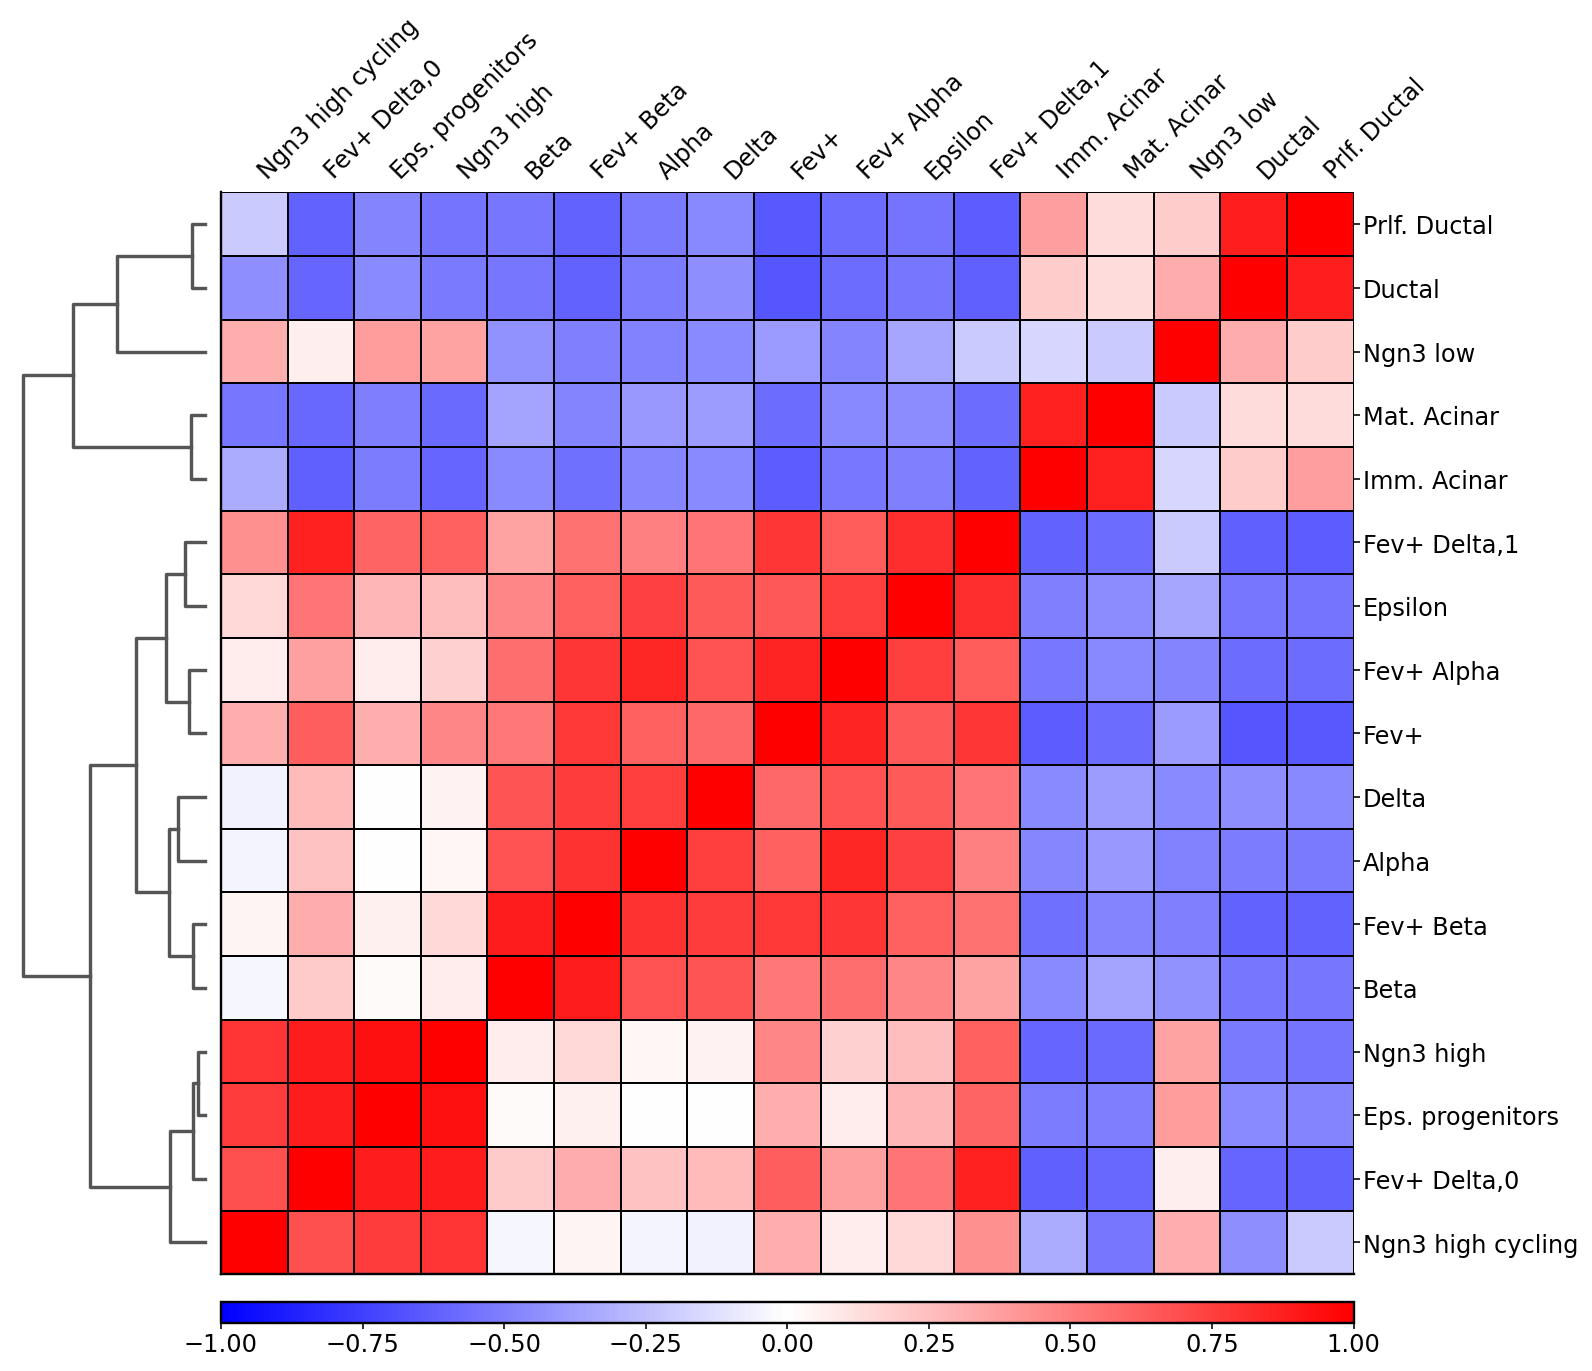

In [8]:
fig = sc.pl.correlation_matrix(adata, "cell_type_refined", show=False)

In [9]:
fig[0].figure.savefig(os.path.join(output_dir, 'correlation_matrix_rna.png'))

In [10]:
adata_atac = mudata["atac"]
adata_atac.obs["cell_type_refined"] = mudata.obs["cell_type_refined"] 

In [11]:
depth_corr = [np.corrcoef(adata_atac.obsm["X_lsi"][:,i], adata_atac.obs["n_counts"])[1,0] for i in range(adata_atac.obsm["X_lsi"].shape[1])]

In [12]:
comps_to_remove = np.where(np.abs(depth_corr) > 0.3)[0]
comps_to_remove

array([2])

In [13]:
subset = list(set(range(adata_atac.obsm["X_lsi"].shape[1])) - set(comps_to_remove))
adata_atac.obsm['X_lsi_red'] = adata_atac.obsm['X_lsi'][:,subset]

In [14]:
sc.tl.dendrogram(adata_atac, groupby="cell_type_refined", use_rep="X_lsi_red")

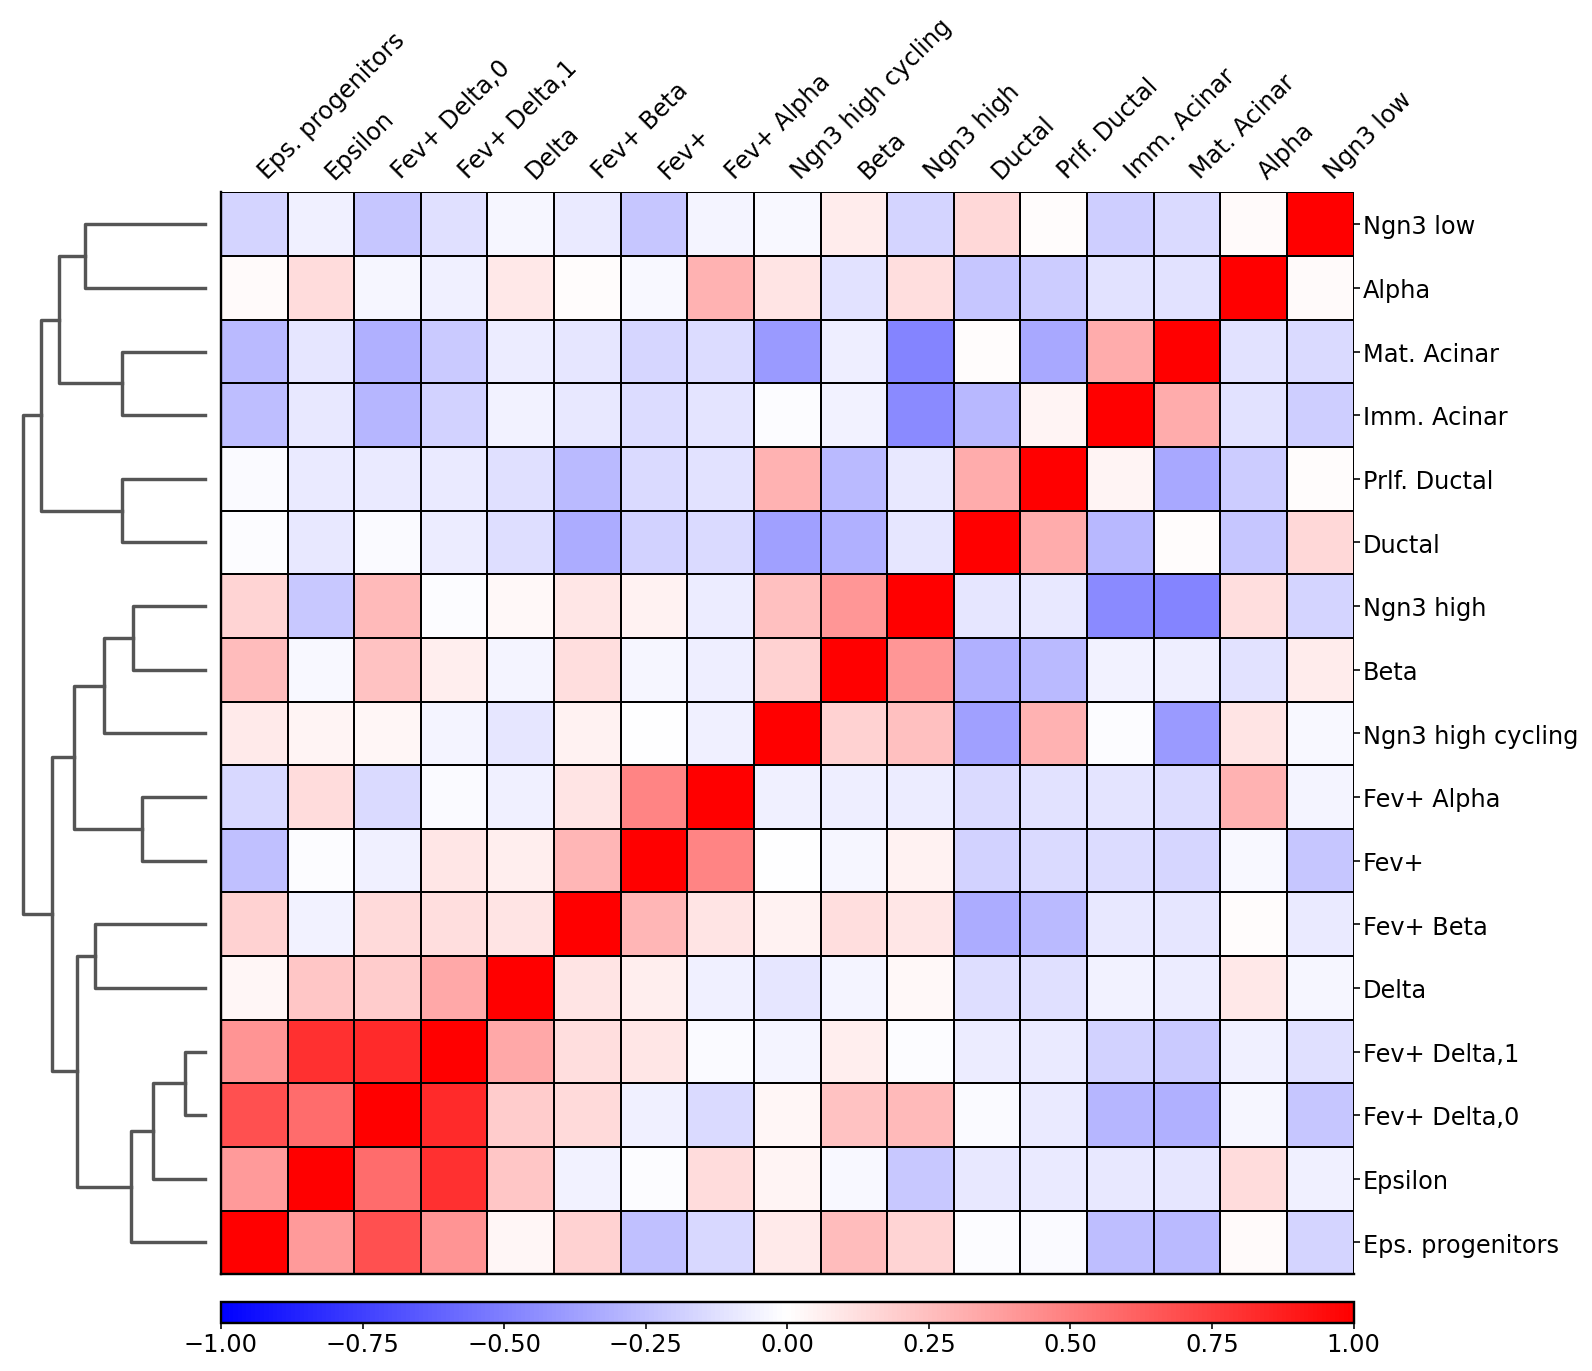

In [15]:
fig = sc.pl.correlation_matrix(adata_atac, "cell_type_refined", show=False)

In [16]:
fig[0].figure.savefig(os.path.join(output_dir, 'correlation_matrix_atac.png'))

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
adata.obsm["combined"] = np.hstack((StandardScaler().fit_transform(adata.obsm["X_pca"]), StandardScaler().fit_transform(adata_atac.obsm["X_lsi_red"])))

In [19]:
sc.tl.dendrogram(adata, groupby="cell_type_refined", use_rep="combined")

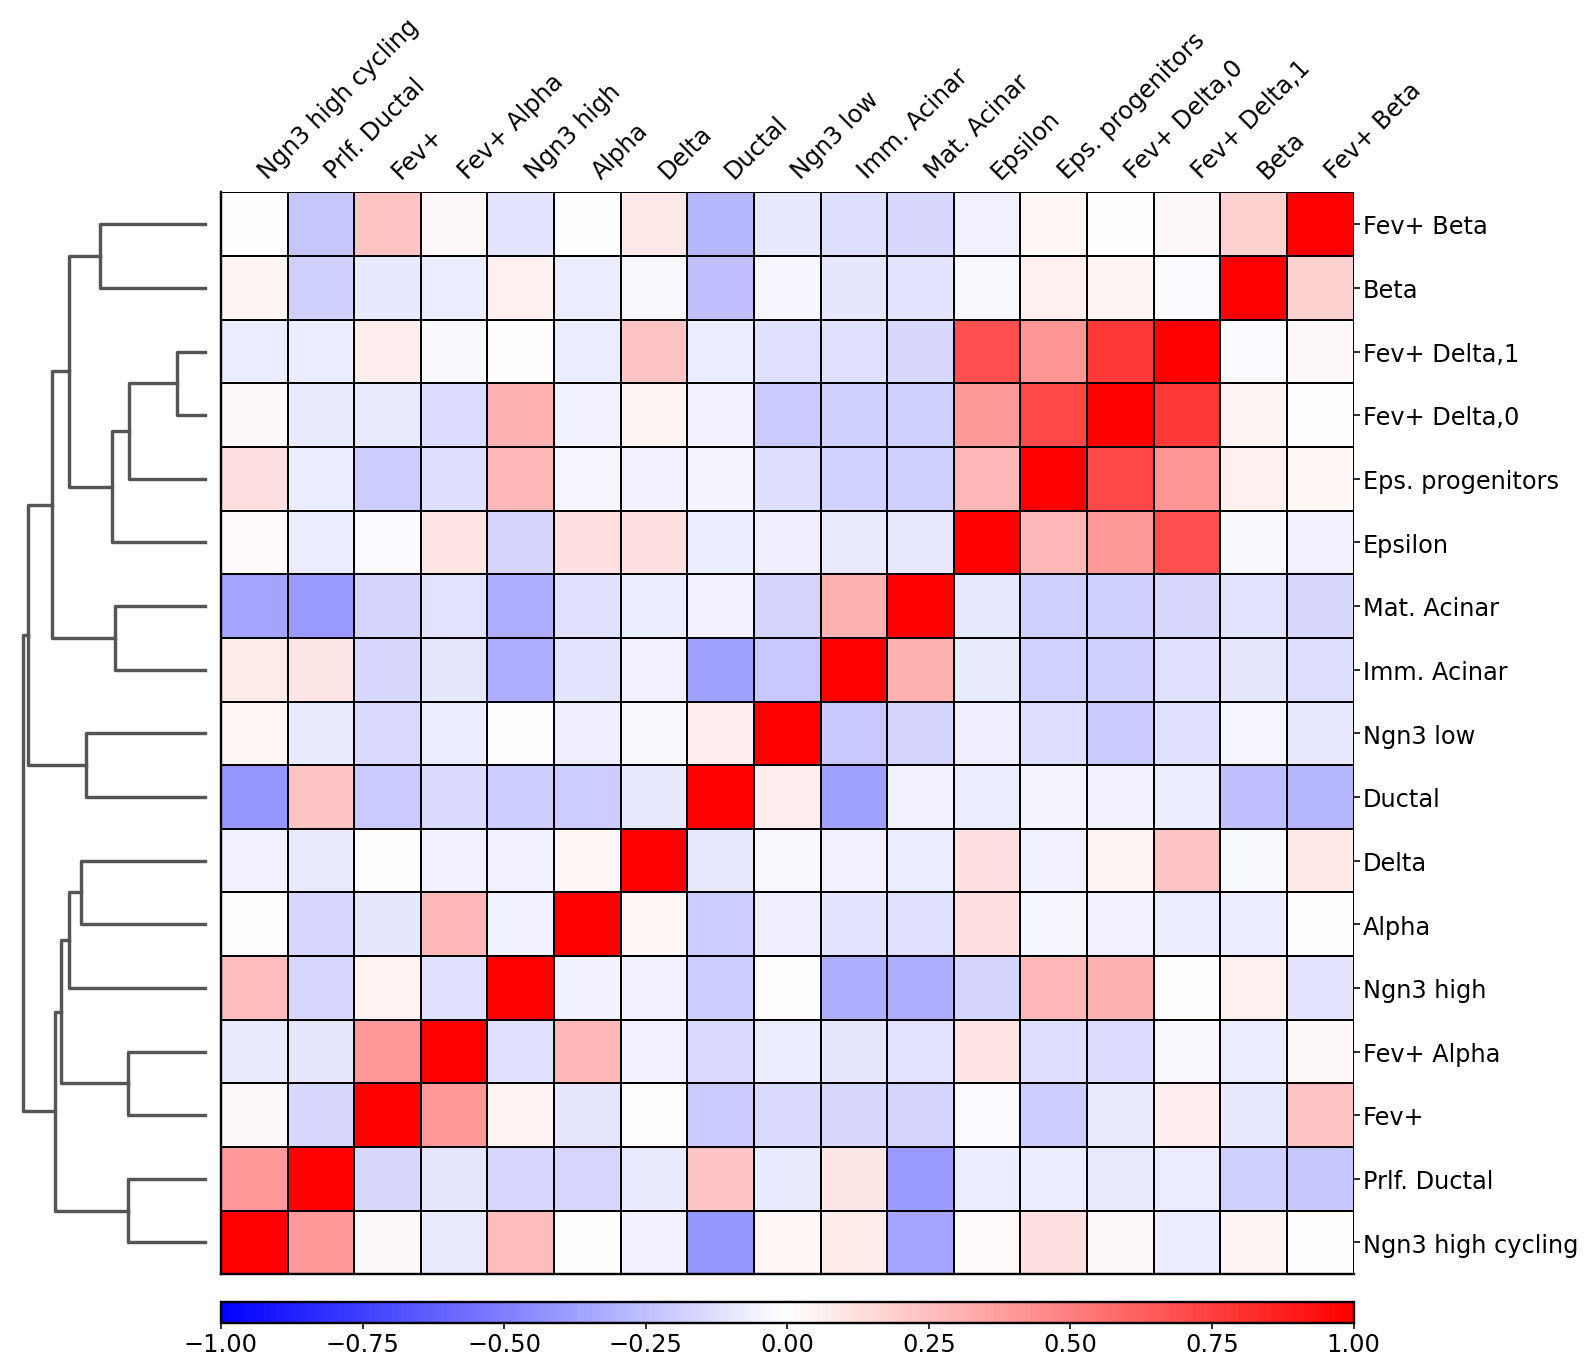

In [20]:
fig = sc.pl.correlation_matrix(adata, "cell_type_refined", show=False)

In [21]:
fig[0].figure.savefig(os.path.join(output_dir, 'correlation_matrix_combined.png'))